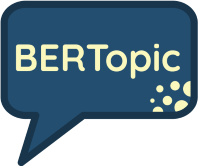

* BERTopic is a model that uses transformers to create topics. In short, it's topic modelling with BERT.

* Using a transformer-based language model already represents an advance to other topic modelling techniques, such as LDA and NMF, which extract topics based on the co-occurrence of words. It also outperforms models like Top2Vec because BERT is bidirectional, being able to generate more contextualized embeddings.

* Furthermore, BERTopic creates word clusters from a variation of the traditional TF-IDF, which the authors call class-based TF-IDF (c-TF-IDF). Instead of calculating the term frequency weighted by the term frequency in the documents, BERTopic converts each cluster into a single document (class) to calculate the TF-IDF. Thus, the set of words with the highest c-TF-IDF is highly representative of its cluster.


* See more in:

  [BERTopic GitHub](https://maartengr.github.io/BERTopic/index.html)

  [Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure.](https://arxiv.org/abs/2203.05794)


* For a comparison between LDA, NMF, Top2Vec and BERTopic, see:

  [Egger, R. and Yu, J. (2022). A Topic Modeling Comparison Between LDA, NMF, Top2Vec, and BERTopic to Demystify Twitter Posts.](https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full)

# Installing and importing



In [1]:
pip install bertopic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd

# Reading documents
Our dataset will be the 3929 headlines of news stories about covid-19 published by the British newspaper The Guardian from January 1st to March 31st, 2020. The excel file also contains the full texts. Feel free to test BERTopic on them!

In [4]:
df = pd.read_excel('C:/Users/luiz_neves/Documents/guardian_covid.xlsx')
df[:10]

date                                           headline  \
0 2020-01-04  Mystery viral outbreak in Hong Kong revives fe...   
1 2020-01-05  Mystery illness in Chinese city not Sars, say ...   
2 2020-01-09  China pneumonia outbreak may be caused by Sars...   
3 2020-01-09   China's Sars-like illness worries health experts   
4 2020-01-11    First death from China mystery illness outbreak   
5 2020-01-14  Case of mystery Sars-like illness found outsid...   
6 2020-01-16  Japan confirms first case of new China coronav...   
7 2020-01-18  Expert questions effectiveness of coronavirus ...   
8 2020-01-18  Coronavirus: Australia's top health official s...   
9 2020-01-18  No screening for new Sars-like virus at UK air...   

          section                                                url  \
0           world  https://www.theguardian.com/world/2020/jan/04/...   
1           world  https://www.theguardian.com/world/2020/jan/05/...   
2         science  https://www.theguardian.com/science/2020/jan/0...   
3           world  https://www.theguardian.com/world/2020/jan/09/...   
4           world  https://www.theguardian.com/world/2020/jan/11/...   
5           world  https://www.theguardian.com/world/2020/jan/14/...   
6           world  https://www.theguardian.com/world/2020/jan/16/...   
7         society  https://www.theguardian.com/society/2020/jan/1...   
8  australia-news  https://www.theguardian.com/australia-news/202...   
9           world  https://www.theguardian.com/world/2020/jan/18/...   

                                           full_text  
0  Hong Kong authorities have moved to “serious r...  
1  A mysterious respiratory illness that has infe...  
2  A cluster of more than 50 pneumonia cases in t...  
3  The finding that the outbreak of viral pneumon...  
4  A 61-year-old man has died from pneumonia in t...  
5  Health authorities have confirmed that a woman...  
6  Japan has confirmed its first case of infectio...  
7  Medical staff at airports trying to screen for...  
8  Australia’s top health official says there is ...  
9  Health officials have ruled out introducing sc...

In [5]:
docs = df['headline']
docs[:10]

0    Mystery viral outbreak in Hong Kong revives fe...
1    Mystery illness in Chinese city not Sars, say ...
2    China pneumonia outbreak may be caused by Sars...
3     China's Sars-like illness worries health experts
4      First death from China mystery illness outbreak
5    Case of mystery Sars-like illness found outsid...
6    Japan confirms first case of new China coronav...
7    Expert questions effectiveness of coronavirus ...
8    Coronavirus: Australia's top health official s...
9    No screening for new Sars-like virus at UK air...
Name: headline, dtype: object

In [6]:
timestamps = df['date']
timestamps[:10]

0   2020-01-04
1   2020-01-05
2   2020-01-09
3   2020-01-09
4   2020-01-11
5   2020-01-14
6   2020-01-16
7   2020-01-18
8   2020-01-18
9   2020-01-18
Name: date, dtype: datetime64[ns]

# Guided Topic Modeling
Here we will use the 5 steps suggested as default by BERTopic. But each step is customizable, so you can use whichever model you prefer.

In [6]:
# Step 1 - Extract embeddings.
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality.
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings.
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics.
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation.
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
    language='english', # Set to 'multilingual' for datasets with languages other than English.
    top_n_words=10,
    n_gram_range=(1, 1),
    min_topic_size=10,
    nr_topics=None,
    low_memory=False,
    calculate_probabilities=True, # The probabilities of all topics per document.
    diversity=None,
    seed_topic_list=None, # Like CorEx
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    verbose=False
)

topics, probs = topic_model.fit_transform(docs) # Fit the model and predict documents.

# Getting general information about the topics

In [7]:
# A dataframe with all the generated topics.

info = topic_model.get_topic_info()
info

# -1 refers to outlliers and should typically be ignored.
# 'Count' is the number o documents on the topic.

Topic  Count                                            Name
0      -1   1112               -1_coronavirus_uk_pandemic_crisis
1       0    233              0_coronavirus_view_guardian_crisis
2       1    198                1_league_football_players_season
3       2    162                         2_china_chinese_xi_sars
4       3    147                               3_covid_19_nhs_uk
5       4    145  4_australia_australian_australians_coronavirus
6       5    130              5_schools_school_students_closures
7       6    129                6_markets_global_economic_market
8       7    119                7_nhs_doctors_hospitals_hospital
9       8    117              8_travel_airlines_flights_industry
10      9    109           9_supermarkets_shopping_food_shoppers
11     10    101             10_distancing_isolation_social_self
12     11    100                 11_trump_donald_pence_democrats
13     12     93            12_uk_britain_coronavirus_government
14     13     91                    13_workers_pay_employed_sick
15     14     87                  14_italy_italian_lockdown_sing
16     15     80                 15_cruise_ship_princess_diamond
17     16     74              16_theatre_music_cinemas_streaming
18     17     67                     17_testing_test_positive_uk
19     18     60          18_prisoners_trials_prison_immigration
20     19     50                19_johnson_boris_press_briefings
21     20     47              20_lockdown_necessary_police_boris
22     21     44              21_stimulus_morrison_package_scott
23     22     43            22_wuhan_evacuation_flight_christmas
24     23     42                     23_bank_banks_england_funds
25     24     31                   24_olympics_tokyo_olympic_ioc
26     25     27                25_zealand_new_zealanders_ardern
27     26     25                          26_york_cuomo_new_city
28     27     25                   27_wuhan_doctor_outbreak_city
29     28     24              28_europe_singapore_spread_germany
30     29     22                   29_spain_spanish_flu_survivor
31     30     22                         30_racing_f1_prix_grand
32     31     22                  31_vote_voters_elections_putin
33     32     21      32_festival_cancelled_festivals_cheltenham
34     33     20            33_lockdown_tighten_london_lockdowns
35     34     20                      34_sunak_rishi_budget_deal
36     35     19                      35_korea_south_sect_korean
37     36     18                    36_hand_sanitiser_wash_hands
38     37     18   37_ventilators_ventilator_build_manufacturers
39     38     18                      38_masks_face_mask_goggles
40     39     17                39_iran_sanctions_shrines_arabia

In [8]:
# A dataframe with general information about the topics.

get_document_info = topic_model.get_document_info(docs)
get_document_info[:10]

AttributeError: 'BERTopic' object has no attribute 'get_document_info'

In [9]:
# A dictionary with the top n terms per topic (default=10) and their respective c-TF-IDF values.

t = topic_model.topic_representations_
t

{-1: [('coronavirus', 0.02156668352798968),
  ('uk', 0.011365018282125121),
  ('pandemic', 0.010510411414437487),
  ('crisis', 0.010277390545554644),
  ('quarantine', 0.009997564603051607),
  ('covid', 0.00958464004248053),
  ('people', 0.009583218552253261),
  ('19', 0.009386619183451959),
  ('outbreak', 0.00931856686072241),
  ('amid', 0.00873830219135535)],
 0: [('coronavirus', 0.039756581427331183),
  ('view', 0.03209133178252303),
  ('guardian', 0.03122033882113506),
  ('crisis', 0.028331504300356945),
  ('society', 0.020491888634521043),
  ('observer', 0.01847062955720253),
  ('health', 0.018346648756222106),
  ('experts', 0.01812429326056273),
  ('pandemic', 0.017384321333324567),
  ('fight', 0.01600264624472184)],
 1: [('league', 0.05854598365998587),
  ('football', 0.05338468363328465),
  ('players', 0.04967709294282102),
  ('season', 0.048593146134608134),
  ('clubs', 0.038974688665440904),
  ('sport', 0.03576899887275042),
  ('premier', 0.03533375817291301),
  ('fans', 0.032

In [10]:
# Accessing single topics (10 words by default).

topic_model.get_topic(0)

[('coronavirus', 0.039756581427331183),
 ('view', 0.03209133178252303),
 ('guardian', 0.03122033882113506),
 ('crisis', 0.028331504300356945),
 ('society', 0.020491888634521043),
 ('observer', 0.01847062955720253),
 ('health', 0.018346648756222106),
 ('experts', 0.01812429326056273),
 ('pandemic', 0.017384321333324567),
 ('fight', 0.01600264624472184)]

In [11]:
# Getting the 3 most representative docs per topic.

topic_model.get_representative_docs(0)

['Coronavirus exposes the danger of embracing protectionism',
 'We are at war with coronavirus. Everyone will have to muck in',
 'Coronavirus outbreak: the key scientific questions answered']

In [12]:
# Defining our own labels for each topic.
# TIP! When first looking at topics, be more descriptive and specific than general.

topic_labels = {-1: "Outlier", 0: "Understanding the disease", 1: "Impact on football events", 2: "Outbreak in China",
                3: "Outbreak in UK", 4:"Impact on education", 5: "Impact on supply", 6: "Economic consequences", 7: "Impact on NHS",
                8: "Social isolation", 9: "Impact on travel", 10: "Trump's measures", 11: "UK's measures", 12: "Outbreak in Italy",
                13: "Outbreak on cruises", 14: "Impact on cultural events", 15: "Impact on the workforce", 16: "Testing",
                17: "Outbreak in prisons", 18: "Boris Johnson's response", 19: "Outbreak in Australia", 20: "Morrison's measures",
                21: "Lockdown", 22: "Economic consequences", 23: "Evacuation from Wuhan", 24: "Impact on the Olympics",
                25: "Outbreak in New Zealand", 26: "Consequences on Australia's economy", 27: "Outbreak in New York", 28: "Outbreak in Europe", 29: "Lockdown",
                30: "Impact on elections", 31: "Outbreak in Wuhan", 32: "Impact on cultural events", 33: "Outbreak in Spain",
                34: "Rishi Sunak's economic response", 35: "Outbreak in South Korea", 36: "Outbreak in California", 37: "Hand sanitizer",
                38: "Ventilators", 39: "Masks", 40: "Outbreak in Middle East", 41: "Vulnerable groups", 42: "Impact on sports"
}

topic_model.set_topic_labels(topic_labels)

Here we can get the first insights into our corpus. The topics are apparently related to the following subjects:
- Efforts to understand and combat the new disease;
- The spread of the coronavirus around the world from Wuhan;
- Impacts on various sectors of society, such as the economy, education and sporting, artistic and cultural events;
- Monitoring and protection measures, such as testing, social isolation, hand sanitiser and masks.

These subjects seem to be quite consistent with our corpus, as it concerns the first 3 months of the outbreak of the new coronavirus.

# Visualisation

## Barchart
Visualise a barchart of selected topics.

In [13]:
topic_model.visualize_barchart(topics=None, top_n_topics=8, n_words=10, custom_labels=True, width=250, height=350,)

## Intertopic Distance Map
Visualise topics, their sizes, and their corresponding words. You can hover over the figure to see the topics. The bar at the bottom of the figure highlights the topics.

In [14]:
topic_model.visualize_topics()

# Documents in 2D
Visualise the documents of each topic in 2D. Hover over the figure to see the documents. To facilitate the visualisation, you can also select the topics to highlight them.

In [15]:
topic_model.visualize_documents(docs, custom_labels=True, width=1000, height=750)

# Hierarchical Topics
Visualise a hierarchical structure of the topics.

In [16]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(custom_labels=True, width=1000, height=600, hierarchical_topics=hierarchical_topics, color_threshold=1.5)

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 398.21it/s]


# Heatmap
Visualise a heatmap of the topic's similarity matrix.

In [17]:
topic_model.visualize_heatmap(custom_labels=True)

# Topic Probabilities per Document
Choose a document and see the probabilities of topics it may belong to.

In [18]:
topic_model.visualize_distribution(probs[1], min_probability=0.015, custom_labels=True)

# Approximate Distribution
Visualise the topic distribution in a document, but on a token level. It indicates the extent to which a certain word belongs to a specific topic.

In [19]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

distr = topic_model.visualize_approximate_distribution(docs[20], topic_token_distr[20])
distr

AttributeError: 'BERTopic' object has no attribute 'approximate_distribution'

# Topics Over Time
Visualise topics over time. Remember that you must have a dataset containing the documents' dates. Select the topics in the figure for better visualisation.

In [20]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5, custom_labels=True, width=1000, height=450)

# Querying Topics by Keywords
One interesting function of BERTopic is finding topics most similar to a search term. It creates an embedding for the keyword and compares that with the topic embeddings. The most similar topics are returned along with their similarity values. The search term can be of any size, but since it compares with the topic representation, it is advised to keep it below 5 words.

In [21]:
topic_model.find_topics('fear', top_n=5)

([0, -1, 20, 6, 10],
 [0.5288803990153007,
  0.4940647536521625,
  0.48612032143120126,
  0.4584584534680275,
  0.45779182061251045])

# Functions query() and query_list() to get a summary of a given keyword or a set of keywords

## query() – to query a single keyword

In [22]:
def query(keyword, n_topics, save_output=False):
  """
  -> From a given keyword, it creates a dataframe with the related topics and their representative documents.
  :keyword: the term you want to search
  :number: the number of topics related to the given keyword
  :save_output: save the dataframe as an excel file
  :return: dataframe
  """
  summary = []
  for b in range (0, (n_topics)):
      df = {}
      df['Keyword'] = keyword
      df['Topic_number'] = topic_model.find_topics(keyword, top_n=n_topics)[0][b]
      df['Score'] = topic_model.find_topics(keyword, top_n=n_topics)[1][b]
      df['Topic_label'] = topic_labels[df['Topic_number']]
      df['Words'] = []
      for c in range (0, 10):
          word = topic_model.get_topic(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[c][0]
          df['Words'].append(word)
      df['Tf-idf'] = []
      for d in range (0, 10):
          tf_idf = topic_model.get_topic(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[d][1]
          df['Tf-idf'].append(tf_idf)
      if df['Topic_number'] != -1: # When the topic is -1 (outlier), BERTopic doesn't give the documents.
          df['Rep_doc1'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[0]
          df['Rep_doc2'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[1]
          df['Rep_doc3'] = topic_model.get_representative_docs(topic_model.find_topics(keyword, top_n=n_topics)[0][b])[2]
          summary.append(df)
      else: # We must pass NULL values in case the topic is -1.
          df['Rep_doc1'] = 'NULL'
          df['Rep_doc2'] = 'NULL'
          df['Rep_doc3'] = 'NULL'
          summary.append(df)
      sum = pd.DataFrame(summary)
      if save_output:
          sum.to_excel('C:/Users/luiz_neves/Documents/summary.xlsx')
  return(sum)

In [23]:
query('fear', 5, save_output=True)

Keyword  Topic_number     Score                Topic_label  \
0    fear             0  0.528880  Understanding the disease   
1    fear            -1  0.494065                    Outlier   
2    fear            20  0.486120        Morrison's measures   
3    fear             6  0.458458      Economic consequences   
4    fear            10  0.457792           Trump's measures   

                                               Words  \
0  [coronavirus, view, guardian, crisis, society,...   
1  [coronavirus, uk, pandemic, crisis, quarantine...   
2  [lockdown, necessary, police, boris, johnson, ...   
3  [markets, global, economic, market, recession,...   
4  [distancing, isolation, social, self, physical...   

                                              Tf-idf  \
0  [0.039756581427331183, 0.03209133178252303, 0....   
1  [0.02156668352798968, 0.011365018282125121, 0....   
2  [0.1991498417812375, 0.054290495740371036, 0.0...   
3  [0.0890082281023544, 0.05775765632601329, 0.05...   
4  [0.09620926416610638, 0.083532761604775, 0.072...   

                                            Rep_doc1  \
0  Coronavirus exposes the danger of embracing pr...   
1                                               NULL   
2      Do you have a question about the UK lockdown?   
3  The stock markets have rallied, so is peak pan...   
4  Finally working on that novel as you self-isol...   

                                            Rep_doc2  \
0  We are at war with coronavirus. Everyone will ...   
1                                               NULL   
2  Anger grows among Britons on holiday as lockdo...   
3  Global markets rally after biggest Chinese fal...   
4  UK privacy activists raise fears over social d...   

                                            Rep_doc3  
0  Coronavirus outbreak: the key scientific quest...  
1                                               NULL  
2  UK police use drones and roadblocks to enforce...  
3  Panic hits global markets amid threat of coron...  
4  Don't just blame the public over social distan...

## query_list() – to query a list of keywords

In [24]:
def query_list(list_keywords, n_topics, save_output=False):
  """
  -> From a list of keywords, it creates a dataframe with the related topics and their representative documents.
  :list_keywords: the terms you want to search
  :n_topics: the number of topics related to the given list of keywords
  :save_output: save the dataframe as an excel file
  :return: dataframe
  """
  sum_list = pd.DataFrame()
  cont = 0
  for k in list_keywords:
      y = query(list_keywords[cont], n_topics)
      sum_list = pd.concat([sum_list, y])
      cont += 1
  if save_output:
      sum_list.to_excel('C:/Users/luiz_neves/Documents/summary_list.xlsx')
  return(sum_list)

In [25]:
my_list = ['vaccine', 'science', 'fake news']

query_list(my_list, 5, save_output=True)

Keyword  Topic_number     Score                Topic_label  \
0    vaccine            -1  0.516055                    Outlier   
1    vaccine             0  0.452087  Understanding the disease   
2    vaccine             3  0.400162             Outbreak in UK   
3    vaccine            36  0.386427     Outbreak in California   
4    vaccine            38  0.367209                Ventilators   
0    science             5  0.561001           Impact on supply   
1    science            10  0.550723           Trump's measures   
2    science            17  0.541954        Outbreak in prisons   
3    science             0  0.509698  Understanding the disease   
4    science             1  0.485372  Impact on football events   
0  fake news            11  0.422393              UK's measures   
1  fake news            31  0.383980          Outbreak in Wuhan   
2  fake news            17  0.382892        Outbreak in prisons   
3  fake news             0  0.351679  Understanding the disease   
4  fake news            13  0.351543        Outbreak on cruises   

                                               Words  \
0  [coronavirus, uk, pandemic, crisis, quarantine...   
1  [coronavirus, view, guardian, crisis, society,...   
2  [covid, 19, nhs, uk, frontline, strategy, view...   
3  [hand, sanitiser, wash, hands, handwashing, sa...   
4  [masks, face, mask, goggles, use, medical, rai...   
0  [schools, school, students, closures, universi...   
1  [distancing, isolation, social, self, physical...   
2  [testing, test, positive, uk, tests, dies, cor...   
3  [coronavirus, view, guardian, crisis, society,...   
4  [league, football, players, season, clubs, spo...   
0  [trump, donald, pence, democrats, mike, corona...   
1  [vote, voters, elections, putin, primaries, el...   
2  [testing, test, positive, uk, tests, dies, cor...   
3  [coronavirus, view, guardian, crisis, society,...   
4  [workers, pay, employed, sick, self, universal...   

                                              Tf-idf  \
0  [0.02156668352798968, 0.011365018282125121, 0....   
1  [0.039756581427331183, 0.03209133178252303, 0....   
2  [0.14320727163287097, 0.1415089086297597, 0.02...   
3  [0.3198697971221348, 0.1796099462814906, 0.143...   
4  [0.36159047843712966, 0.18869731753416286, 0.0...   
0  [0.125697606125595, 0.08898134284325587, 0.084...   
1  [0.09620926416610638, 0.083532761604775, 0.072...   
2  [0.07716517308368769, 0.07114384933748896, 0.0...   
3  [0.039756581427331183, 0.03209133178252303, 0....   
4  [0.05854598365998587, 0.05338468363328465, 0.0...   
0  [0.21966191190536558, 0.06899177699531626, 0.0...   
1  [0.18494170555657788, 0.12185813197448166, 0.1...   
2  [0.07716517308368769, 0.07114384933748896, 0.0...   
3  [0.039756581427331183, 0.03209133178252303, 0....   
4  [0.10811917880919861, 0.060552551440839646, 0....   

                                            Rep_doc1  \
0                                               NULL   
1  Coronavirus exposes the danger of embracing pr...   
2  Covid-19 presents people in the crosshairs of ...   
3  UK blood couriers 'not given gloves and hand s...   
4  Our face mask future: Do they really help beat...   
0  Pupils are joking that they're 'dying to learn...   
1  Finally working on that novel as you self-isol...   
2  Cross-Whitehall unit set up to counter false c...   
3  Coronavirus exposes the danger of embracing pr...   
4  Scotland Women's Six Nations game off as playe...   
0  Coronavirus: Trump's stumbles and testing fail...   
1  Coronavirus delays Russian vote on Putin stayi...   
2  Cross-Whitehall unit set up to counter false c...   
3  Coronavirus exposes the danger of embracing pr...   
4  Coronavirus crisis: paid sick leave is a start...   

                                            Rep_doc2  \
0                                               NULL   
1  We are at war with coronavirus. Everyone will ...   
2  'This really hurts': man shares Covid-19 exper...   
3  Perfume giant 

In [26]:
pip install pySankey

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from pySankey import sankey

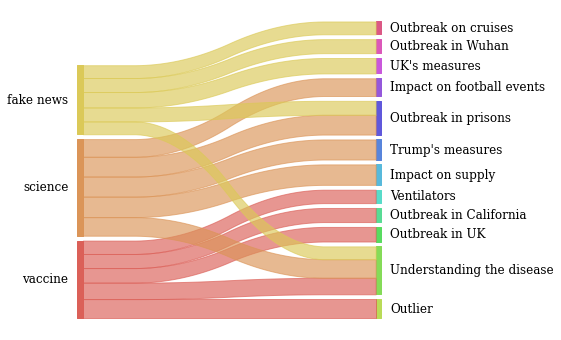

In [28]:
summary_list = pd.read_excel('C:/Users/luiz_neves/Documents/summary_list.xlsx')
sankey.sankey(left=summary_list['Keyword'], right=summary_list['Topic_label'], leftWeight=summary_list['Score'], rightWeight=summary_list['Score'],
              aspect=20, fontsize=12)

# BONUS! Creating dataframes to organize the data

In [29]:
# Creating a dataframe with the Topic Representations.
dict = topic_model.topic_representations_
df_general_info = pd.DataFrame(list(dict.items()), columns = ['topic', 'word_tf_idf'])

# Adding the column Topic Embeddings
df_general_info['embed'] = topic_model.topic_embeddings_

# The embeddings for each topic are calculated by taking the weighted average
# of word embeddings in a topic based on their c-TF-IDF values.

df_general_info

topic                                        word_tf_idf  \
0      -1  [(coronavirus, 0.02156668352798968), (uk, 0.01...   
1       0  [(coronavirus, 0.039756581427331183), (view, 0...   
2       1  [(league, 0.05854598365998587), (football, 0.0...   
3       2  [(china, 0.1536156208276311), (chinese, 0.0796...   
4       3  [(covid, 0.14320727163287097), (19, 0.14150890...   
5       4  [(australia, 0.08840940942456468), (australian...   
6       5  [(schools, 0.125697606125595), (school, 0.0889...   
7       6  [(markets, 0.0890082281023544), (global, 0.057...   
8       7  [(nhs, 0.14466634481822432), (doctors, 0.06856...   
9       8  [(travel, 0.12248354052646963), (airlines, 0.0...   
10      9  [(supermarkets, 0.07504176422630301), (shoppin...   
11     10  [(distancing, 0.09620926416610638), (isolation...   
12     11  [(trump, 0.21966191190536558), (donald, 0.0689...   
13     12  [(uk, 0.09315917839138703), (britain, 0.048129...   
14     13  [(workers, 0.10811917880919861), (pay, 0.06055...   
15     14  [(italy, 0.22291881992515702), (italian, 0.107...   
16     15  [(cruise, 0.21342089406902748), (ship, 0.19817...   
17     16  [(theatre, 0.07924109599195918), (music, 0.074...   
18     17  [(testing, 0.07716517308368769), (test, 0.0711...   
19     18  [(prisoners, 0.07832213564627342), (trials, 0....   
20     19  [(johnson, 0.32497371159076904), (boris, 0.264...   
21     20  [(lockdown, 0.1991498417812375), (necessary, 0...   
22     21  [(stimulus, 0.20738441386916265), (morrison, 0...   
23     22  [(wuhan, 0.18114043911602581), (evacuation, 0....   
24     23  [(bank, 0.1590437710171197), (banks, 0.1266345...   
25     24  [(olympics, 0.30164378864899205), (tokyo, 0.26...   
26     25  [(zealand, 0.27158485146344763), (new, 0.17857...   
27     26  [(york, 0.2818475645315886), (cuomo, 0.1648235...   
28     27  [(wuhan, 0.3473629672314055), (doctor, 0.07305...   
29     28  [(europe, 0.13321779358547994), (singapore, 0....   
30     29  [(spain, 0.2861804694842905), (spanish, 0.1533...   
31     30  [(racing, 0.20468107440270353), (f1, 0.1954236...   
32     31  [(vote, 0.18494170555657788), (voters, 0.12185...   
33     32  [(festival, 0.25559949046238917), (cancelled, ...   
34     33  [(lockdown, 0.18846299167390124), (tighten, 0....   
35     34  [(sunak, 0.4374073243547963), (rishi, 0.302295...   
36     35  [(korea, 0.3463124015139132), (south, 0.339322...   
37     36  [(hand, 0.3198697971221348), (sanitiser, 0.179...   
38     37  [(ventilators, 0.38646456400827994), (ventilat...   
39     38  [(masks, 0.36159047843712966), (face, 0.188697...   
40     39  [(iran, 0.3490790205816899), (sanctions, 0.129...   

                                                embed  
0   [-0.008569442500083246, 0.03393349979846759, -...  
1   [-0.023155791330749003, 0.0432999728069342, -0...  
2   [-0.02400179049735788, 0.022716351369540727, -...  
3   [-0.020630933330478485, 0.053944435748577046, ...  
4   [-0.0219559372517968, 0.04618578203436913, -0....  
5   [0.016588182928735522, 0.03825332373566297, -0...  
6   [0.010433214610077686, 0.021098365121778206, 0...  
7   [-0.01673718764769367, -0.012515549215255392, ...  
8   [-0.021806023526815217, 0.026711607939764567, ...  
9   [0.036451488464538745, 0.018756897779507224, -...  
10  [-0.0002612902320960423, 0.011807939328485307,...  
11  [-0.03614472619128246, 0.02781512849319875, -0...  
12  [-0.01747363834204561, 0.060555976552165984, 0...  
13  [0.016854257976308212, 0.020772181352918823, -...  
14  [-0.034100076316472036, 0.021313154001941698, ...  
15  [-0.03455554609468605, 0.055888021114293106, -...  
16  [-0.016925211882634218, 0.025023959173682934, ...  
17  [0.024532685199053498, -0.035536826566427544, ...  
18  [-0.0018871777899932593, 0.02507875313411705, ...  
19  [-0.0004637693642085904, 0.04309743975202203, ...  
20  [-0.04863148255301018, 0.012834974959397746, -...  
21  [-0.034481668904663386, 0.036753733087955584, ...  
22  [-0.0382924136694801, 0

In [30]:
# Creating a dataframe with the representative documents per topic.
dict2 = topic_model.representative_docs_
df_rep_docs = pd.DataFrame(list(dict2.items()), columns = ['topic', 'rep_docs'])
df_rep_docs

topic                                           rep_docs
0       2  [More than 1,700 health workers infected by co...
1       6  [The stock markets have rallied, so is peak pa...
2       0  [Coronavirus exposes the danger of embracing p...
3      11  [Coronavirus: Trump's stumbles and testing fai...
4       4  [Reserve Bank boss says coronavirus likely to ...
5      27  [New 1,000-bed Wuhan hospital takes its first ...
6       7  [NHS staff 'gagged' over coronavirus shortages...
7      17  [Cross-Whitehall unit set up to counter false ...
8      28  [French cases show coronavirus has reached Eur...
9      22  [Australians trapped in coronavirus centre Wuh...
10     12  [I’m an epidemiologist. When I heard about Bri...
11      5  [Pupils are joking that they're 'dying to lear...
12     35  [Kim Jong-un sister condemns 'frightened dog' ...
13     15  [Coronavirus: cruise ship passengers at Réunio...
14      1  [Scotland Women's Six Nations game off as play...
15     38  [Our face mask future: Do they really help bea...
16     24  [Abe insists Olympics to go ahead as planned d...
17     36  [UK blood couriers 'not given gloves and hand ...
18      8  [How coronavirus is wreaking havoc with reader...
19     21  [Australian government unveils $17.6bn stimulu...
20     13  [Coronavirus crisis: paid sick leave is a star...
21     30  [F1 drivers prepare for face-off in virtual ra...
22     14  ['This is like a war': view from Italy's coron...
23     23  [Bank of England cancels stress tests for UK's...
24     26  [Coronavirus: states touching New York City re...
25     39  [Iran's deputy health minister: I have coronav...
26      9  [UK supermarkets impose tight new rules to pre...
27     18  [Australia's overcrowded prisons could struggl...
28     19  [Boris Johnson to hold daily coronavirus press...
29     32  [SXSW festival cancelled over coronavirus fear...
30     25  [New Zealand site to report Covid-19 rule-brea...
31      3  [Covid-19 presents people in the crosshairs of...
32     10  [Finally working on that novel as you self-iso...
33     34  [Rishi Sunak vows to do whatever it takes to g...
34     31  [Coronavirus delays Russian vote on Putin stay...
35     29  ['We are naked against the virus': tales of de...
36     20  [Do you have a question about the UK lockdown?...
37     33  [How UK coronavirus lockdown compares with oth...
38     16  [BBC suspends filming of EastEnders due to cor...
39     37  [Detroit automakers shut down plants but worke...

In [31]:
# Creating a df with each topic and the three respective most representative documents.

topics_repdocs = []
for n in range(0, len(info)-1):
    new_df = {}
    new_df['topic'] = n
    new_df['doc1'] = topic_model.get_representative_docs(n)[0]
    new_df['doc2'] = topic_model.get_representative_docs(n)[1]
    new_df['doc3'] = topic_model.get_representative_docs(n)[2]
    topics_repdocs.append(new_df)

guar_topics_repdocs = pd.DataFrame(topics_repdocs)
guar_topics_repdocs

topic                                               doc1  \
0       0  Coronavirus exposes the danger of embracing pr...   
1       1  Scotland Women's Six Nations game off as playe...   
2       2  More than 1,700 health workers infected by cor...   
3       3  Covid-19 presents people in the crosshairs of ...   
4       4  Reserve Bank boss says coronavirus likely to b...   
5       5  Pupils are joking that they're 'dying to learn...   
6       6  The stock markets have rallied, so is peak pan...   
7       7      NHS staff 'gagged' over coronavirus shortages   
8       8  How coronavirus is wreaking havoc with readers...   
9       9  UK supermarkets impose tight new rules to prev...   
10     10  Finally working on that novel as you self-isol...   
11     11  Coronavirus: Trump's stumbles and testing fail...   
12     12  I’m an epidemiologist. When I heard about Brit...   
13     13  Coronavirus crisis: paid sick leave is a start...   
14     14  'This is like a war': view from Italy's corona...   
15     15  Coronavirus: cruise ship passengers at Réunion...   
16     16  BBC suspends filming of EastEnders due to coro...   
17     17  Cross-Whitehall unit set up to counter false c...   
18     18  Australia's overcrowded prisons could struggle...   
19     19  Boris Johnson to hold daily coronavirus press ...   
20     20      Do you have a question about the UK lockdown?   
21     21  Australian government unveils $17.6bn stimulus...   
22     22  Australians trapped in coronavirus centre Wuha...   
23     23  Bank of England cancels stress tests for UK's ...   
24     24  Abe insists Olympics to go ahead as planned de...   
25     25  New Zealand site to report Covid-19 rule-break...   
26     26  Coronavirus: states touching New York City reg...   
27     27  New 1,000-bed Wuhan hospital takes its first c...   
28     28   French cases show coronavirus has reached Europe   
29     29  'We are naked against the virus': tales of des...   
30     30  F1 drivers prepare for face-off in virtual rac...   
31     31  Coronavirus delays Russian vote on Putin stayi...   
32     32     SXSW festival cancelled over coronavirus fears   
33     33  How UK coronavirus lockdown compares with othe...   
34     34  Rishi Sunak vows to do whatever it takes to ge...   
35     35  Kim Jong-un sister condemns 'frightened dog' S...   
36     36  UK blood couriers 'not given gloves and hand s...   
37     37  Detroit automakers shut down plants but worker...   
38     38  Our face mask future: Do they really help beat...   
39     39  Iran's deputy health minister: I have coronavirus   

                                                 doc2  \
0   We are at war with coronavirus. Everyone will ...   
1   Football authorities fear season is unlikely t...   
2   More new coronavirus cases outside China than ...   
3   'This really hurts': man shares Covid-19 exper...   
4   'They would have been slaughtered': Coronaviru...   
5   Shutting schools would reduce coronavirus tran...   
6   Global markets rally after biggest Chinese fal...   
7   NHS staff feel like 'cannon fodder' over lack ...   
8   Southwest Airlines chief compares drop in trav...   
9   Supermarkets to be allowed to increase night-t...   
10  UK privacy activists raise fears over social d...   
11  Google's coronavirus testing sites see little ...   
12  The UK government's woeful response to the cor...   
13  Lack of paid leave will leave millions of US w...   
14  Italy imposes draconian rules to stop spread o...   
15  Coronavirus: thousands who left cruise ship in...   
16  The Invisible Man, Emma and other movies to st...   
17  UK coronavirus testing will increase to 25,000...   
18  Coronavirus is a ticking time bomb for the Aus...   
19  Boris Johnson details raft of new coronavirus ...   
20  Anger grows among Britons on holiday as lockdo...   
21  Australian government signals second round sti...   
22  Australians in Hubei could miss evacuation fli...   
23  Banks w

In [32]:
# Creating a df with all the documents and their respective topic.

guar_doc_topic = pd.DataFrame({'document': docs, 'topic': topics})
guar_doc_topic

document  topic
0     Mystery viral outbreak in Hong Kong revives fe...      2
1     Mystery illness in Chinese city not Sars, say ...      2
2     China pneumonia outbreak may be caused by Sars...      2
3      China's Sars-like illness worries health experts      2
4       First death from China mystery illness outbreak      2
...                                                 ...    ...
3924     Daily UK death toll reaches record high of 381     17
3925  ‘One press-up is better than none’: How Mr Mot...     10
3926  The best Instagram cookalongs to follow in you...     -1
3927  California’s farm workers pick America's essen...     -1
3928  ‘We can’t go back to normal’: how will coronav...      0

[3929 rows x 2 columns]